# load in detrended LCs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def determine_cadence(times):
    time_gaps = {}
    for ii in range(1, len(times)):
        time_gap = np.round(times[ii]-times[ii-1], 4)
        if time_gap in time_gaps.keys():
            time_gaps[time_gap] += 1
        else:
            time_gaps[time_gap] = 1
            
    #find the key that corresponds to the most data gaps, this is the cadence
    cadence = max(time_gaps, key=time_gaps.get)
    return cadence
            
        

In [3]:
import matplotlib 
matplotlib.rc('xtick', labelsize=27) 
matplotlib.rc('ytick', labelsize=27) 

# load in the t0s
t0s = np.genfromtxt('t0s_all.txt', delimiter=',')
if t0s.ndim == 0:
    t0s = np.array([t0s])
    
    
period = 160.884
duration = 10.7536
# # now to plot!

In [4]:
kepler_mm = pd.read_csv('mm_kipping_kepler.dat', delimiter='\t', header=None, names=['time', 'flux', 'flux_err'])
baro_mm = pd.read_csv('mm_kipping_baro.dat', delimiter='\t', header=None, names=['time', 'flux', 'flux_err'])
baron_mm = pd.read_csv('mm_kipping_baron.dat', delimiter='\t', header=None, names=['time', 'flux', 'flux_err'])
tess_mm = pd.read_csv('mm_kipping_tess.dat', delimiter=' ', header=None, names=['time', 'flux', 'flux_err'])


x_kepler_mm, y_kepler_mm, yerr_kepler_mm = kepler_mm['time']+2400000-2454833, kepler_mm['flux']-1, kepler_mm['flux_err']
x_baro_mm, y_baro_mm, yerr_baro_mm = baro_mm['time']+2400000-2454833, baro_mm['flux']-1, baro_mm['flux_err']
x_baron_mm, y_baron_mm, yerr_baron_mm = baron_mm['time']+2400000-2454833, baron_mm['flux']-1, baron_mm['flux_err']
x_tess_mm, y_tess_mm, yerr_tess_mm = tess_mm['time']+2400000-2454833, tess_mm['flux']-1, tess_mm['flux_err']



In [5]:
x = np.concatenate((x_kepler_mm.values, x_baro_mm.values, x_baron_mm.values, x_tess_mm.values))
y = np.concatenate((y_kepler_mm.values, y_baro_mm.values, y_baron_mm.values, y_tess_mm.values))
yerr = np.concatenate((yerr_kepler_mm.values, yerr_baro_mm.values, yerr_baron_mm.values, yerr_tess_mm.values))


In [6]:
t0s

array([ 277.504085  ,  438.38873587,  760.15803761,  921.04268848,
       1081.92733935, 1242.81199022, 1403.69664109, 1564.58129196,
       4943.11      ])

## Transit search

Now, let's use [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/timeseries/bls.html)
(Note: you'll need AstroPy v3.1 or more recent to use this feature) to estimate the period, phase, and depth of the transit.

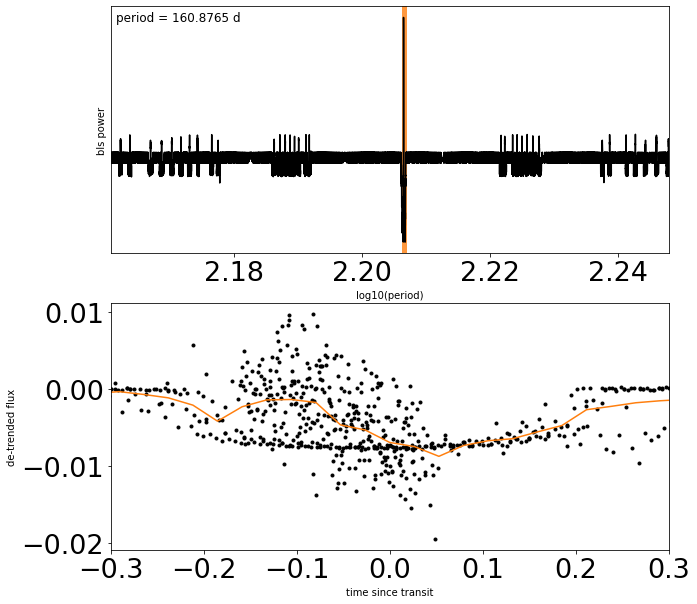

In [7]:

from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(period-.1*period), np.log(period+.1*period), 50000))

bls = BoxLeastSquares(x, y)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(x, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.4f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (x - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold, y, ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux")
_ = ax.set_xlabel("time since transit")

In [8]:
from collections import OrderedDict

texp_kepler = determine_cadence(x_kepler_mm.values)
texp_baro = determine_cadence(x_baro_mm.values)
texp_baron = determine_cadence(x_baron_mm.values)
texp_tess = determine_cadence(x_tess_mm.values)


datasets = OrderedDict(
    [
        ("Kepler", [x_kepler_mm.values, y_kepler_mm.values, yerr_kepler_mm.values, texp_kepler]),
        ("BARO", [x_baro_mm.values, y_baro_mm.values, yerr_baro_mm.values, texp_baro]),
        ("BARON", [x_baron_mm.values, y_baron_mm.values, yerr_baron_mm.values, texp_baron]),
        ("TESS", [x_tess_mm.values, y_tess_mm.values, yerr_tess_mm.values, texp_tess]),
    ]
)
print(bls_t0)
print(t0s[0]+2454833)
datasets

277.54845150711014
2455110.504085


OrderedDict([('Kepler',
              [array([ 274.79345151,  274.8138842 ,  274.8343168 , ..., 1567.2566749 ,
                      1567.27710926, 1567.29754371]),
               array([ 1.34591573e-04, -6.52068323e-05,  3.17914200e-05, ...,
                       8.26584553e-05, -6.51615510e-05, -2.65159057e-05]),
               array([9.84939350e-05, 9.82610940e-05, 9.80573755e-05, ...,
                      9.88612586e-05, 9.84045546e-05, 1.00742059e-04]),
               0.0204]),
             ('BARO',
              [array([4942.8073968 , 4942.80834649, 4942.80929404, 4942.81023848,
                      4942.81118444, 4942.81212983, 4942.81307504, 4942.81402264,
                      4942.81496861, 4942.81591348, 4942.81686073, 4942.81780676,
                      4942.81875185, 4942.81969673, 4942.82064312, 4942.82158908,
                      4942.82253385, 4942.82348087, 4942.82442594, 4942.8253717 ,
                      4942.82631974, 4942.82726681, 4942.82821266, 4942.829157

In [9]:
import pymc3 as pm
import pymc3_ext as pmx
import exoplanet as xo
import aesara_theano_fallback.tensor as tt
from functools import partial
from celerite2.theano import terms, GaussianProcess



# Find a reference transit time near the middle of the observations to avoid
# strong covariances between period and t0
x_min = min(np.min(x) for x, _, _, _ in datasets.values())
x_max = max(np.max(x) for x, _, _, _ in datasets.values())
x_mid = 0.5 * (x_min + x_max)

mid_epoch = np.round((x_mid) / bls_period)
t0_ref = bls_period * np.round((x_mid - t0s[0]) / bls_period)

trans_inds = [0,1,3,4,5,6,7,8,29]


with pm.Model() as model:

    # Shared orbital parameters --> impact parameter, transit times, stellar density
    ###########################
    ###########################
    ###########################
    #stellar density
    log_rho_star = pm.Uniform('log_rho_star', lower=-3, upper=3)
    rho_star = pm.Deterministic('rho_star', tt.exp(log_rho_star))
    
    # impact parameter
    b = pmx.UnitUniform("b")
    #ld_arg = 1 - tt.sqrt(1 - b**2)
    
    # Now we have a parameter for each transit time for each planet:
    transit_times = []
    for i in range(1):
        transit_times.append(
            pm.Normal(
                "tts_{0}".format(i),
                mu=t0s,
                sd=1.0,
                shape=len(t0s),
            )
        )

        
    # Now we have a parameter for each transit time for each planet:
    transit_inds = pm.Deterministic("transit_inds", tt.constant(trans_inds))
    
    
    
    
    # Set up an orbit for the planets
    orbit = xo.orbits.TTVOrbit(b=b, transit_times=transit_times, 
                               rho_star=rho_star, transit_inds=[transit_inds])
    
    

    # It will be useful later to track some parameters of the orbit
    pm.Deterministic("t0", orbit.t0 + orbit.period * mid_epoch)
    pm.Deterministic("period", orbit.period)
    pm.Deterministic("ttvs_{0}".format(i), orbit.ttvs[i])
    
    




    # not shared parameters --> depth and limb-darkening
    # Loop over the instruments
    parameters = dict()
    lc_models = dict()
    for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items()):
        # We define the per-instrument parameters in a submodel so that we
        # don't have to prefix the names manually
        with pm.Model(name=name, model=model):
            # The limb darkening
            u = xo.QuadLimbDark("u")
            star = xo.LimbDarkLightCurve(u)

            # The radius ratio
            #log_approx_depth = pm.Normal(
            #    "log_approx_depth", mu=np.log(4e-3), sigma=10
            #)
            #ld = 1 - u[0] * ld_arg - u[1] * ld_arg**2
            #ror = pm.Deterministic(
            #    "ror", tt.exp(0.5 * log_approx_depth) / tt.sqrt(ld)
            #)
            
            
            #rp_over_rstar 
            ror = pm.Uniform('ror', lower=0, upper=1, testval=(np.sqrt(bls_depth)))
            
            #add TESS blend facotr
            if name == 'TESS':
                blend = pm.Uniform('blend', lower=1, upper=10)
                y = (y+1)/blend - 1
            
    
            
            '''
            # Noise parameters
            med_yerr = np.median(yerr)
            std = np.std(y)
            sigma = pm.InverseGamma(
                "sigma",
                testval=med_yerr,
                **pmx.estimate_inverse_gamma_parameters(
                    med_yerr, 0.5 * std
                ),
            )
            '''

            # Keep track of the parameters for optimization
            if name == 'TESS':
                parameters[name] = [u, ror, blend]
            else:
                parameters[name] = [u, ror]
            #parameters[f"{name}_noise"] = [sigma]

        # The light curve model
        def lc_model(star, ror, texp, t):
            return pm.math.sum(
                star.get_light_curve(orbit=orbit, r=ror, t=t, texp=texp),
                axis=-1,
            )

        lc_model_partial = partial(lc_model, star, ror, texp)
        lc_models[name] = lc_model_partial
        
        lc_model_obs = lc_model(star, ror, texp, x)
        pm.Normal(f"{name}_obs", mu=lc_model_obs, sd=np.sqrt(yerr**2.), observed=y)



    # Optimize the model
    map_soln = model.test_point
    for name in datasets:
        map_soln = pmx.optimize(map_soln, parameters[name])
    for name in datasets:
        #map_soln = pmx.optimize(map_soln, parameters[f"{name}_noise"])
        map_soln = pmx.optimize(map_soln, parameters[name] + [b])
    map_soln = pmx.optimize(map_soln)

optimizing logp for variables: [Kepler_ror, Kepler_u]


message: Desired error not necessarily achieved due to precision loss.
logp: -335772473.94953537 -> -335768490.04727626
optimizing logp for variables: [BARO_ror, BARO_u]


message: Optimization terminated successfully.
logp: -335768490.04727626 -> -335768487.85224223


optimizing logp for variables: [BARON_ror, BARON_u]


message: Desired error not necessarily achieved due to precision loss.
logp: -335768487.85224223 -> -335768485.88419104
optimizing logp for variables: [TESS_blend, TESS_ror, TESS_u]


message: Optimization terminated successfully.
logp: -335768485.88419104 -> 31254.799663654398
optimizing logp for variables: [b, Kepler_ror, Kepler_u]


message: Optimization terminated successfully.
logp: 31254.799663654398 -> 31857.340853964888
optimizing logp for variables: [b, BARO_ror, BARO_u]


message: Optimization terminated successfully.
logp: 31857.340853964888 -> 31857.771330801705


optimizing logp for variables: [b, BARON_ror, BARON_u]


message: Optimization terminated successfully.
logp: 31857.771330801705 -> 31858.694253614874


optimizing logp for variables: [b, TESS_blend, TESS_ror, TESS_u]


message: Desired error not necessarily achieved due to precision loss.
logp: 31858.694253614874 -> 31859.255199694446
optimizing logp for variables: [TESS_blend, TESS_ror, TESS_u, BARON_ror, BARON_u, BARO_ror, BARO_u, Kepler_ror, Kepler_u, tts_0, b, log_rho_star]


message: Desired error not necessarily achieved due to precision loss.
logp: 31859.255199694446 -> 32106.954116124693


[2851.64120288]
[2851.64120288]
[2851.64120288]
[2851.64120288]


/var/folders/9z/bcj7jltn3x5_8y20r9cxql3h0000gn/T/ipykernel_32518/209282648.py:36: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(name,
/var/folders/9z/bcj7jltn3x5_8y20r9cxql3h0000gn/T/ipykernel_32518/209282648.py:36: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(name,
/var/folders/9z/bcj7jltn3x5_8y20r9cxql3h0000gn/T/ipykernel_32518/209282648.py:36: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(name,
/var/folders/9z/bcj7jltn3x5_8y20r9cxql3h0000gn/T/ipykernel_32518/209282648.py:36: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(name,


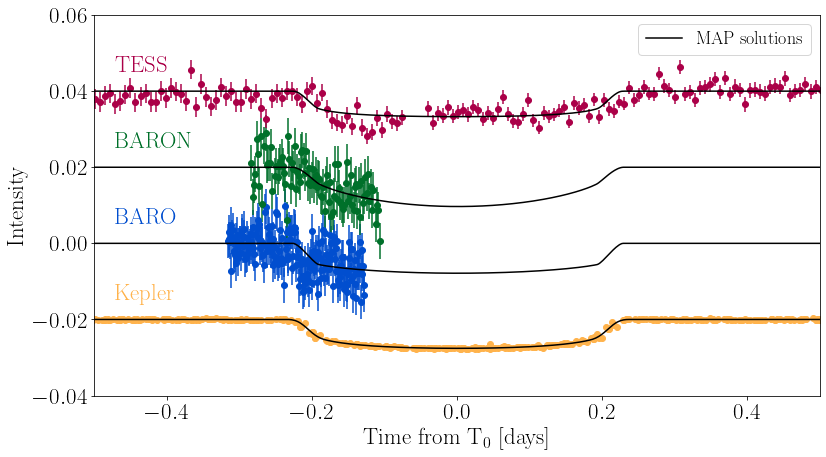

In [10]:
import matplotlib
matplotlib.rc('xtick', labelsize=23) 
matplotlib.rc('ytick', labelsize=23) 
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

dt = np.linspace(-.5, .5, 500)

with model:
    for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items()):
        if name == 'TESS':
            y = (y+1)/map_soln['TESS_blend'] - 1
        phase_curves = pmx.eval_in_model(
                [lc_models[k](t0s[0] + dt) for k in datasets], map_soln
            )

index = 0

colors = ["#ffb34c", "#014ecf", "#00702a", "#ab0048"]
plt.figure(figsize = [13,7])
shift = -0.02
for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items()):
    # Get the posterior median orbital parameters
    p = map_soln["period"]
    t0 = map_soln["t0"]
    print(t0)


    # Plot the folded data
    x_fold = (x - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(
        x_fold, y+shift, yerr=yerr, marker='o', ls='', color=colors[index], zorder=-1000
    )
    
    
    plt.annotate(name, 
                 xy=(-0.47, shift+.005),  
                 xycoords='data',
                 textcoords='offset points',
                 fontsize = 23,
                 color=colors[index])


    
    
    plt.plot(dt, phase_curves[index]+shift, color='k', ms=4, label='MAP solutions')

    index+=1
    shift+=.02
    
    
plt.xlim(-0.5, 0.5)
plt.ylim(-0.04, 0.06)
plt.ylabel("Intensity", fontsize = 23)
plt.xlabel(r"Time from $\textrm{T}_0$ [days]", fontsize = 23)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=18, loc=1)
plt.savefig('map_soln_Feb22.pdf')
    

plt.show()

In [12]:
p

array([160.88320317])

In [84]:
with model:
    print(blend)

TESS_blend ~ Uniform


In [58]:
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=.95,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [TESS_sigma, TESS_ror, TESS_u, BARON_sigma, BARON_ror, BARON_u, BARO_sigma, BARO_ror, BARO_u, Kepler_sigma, Kepler_ror, Kepler_u, tts_0, b, log_rho_star]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 801 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [59]:
import arviz as az

az.summary(trace)

/Users/daniel/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tts_0[0],277.506,0.000,277.505,277.506,0.000,0.000,732.0,948.0,1.01
tts_0[1],438.388,0.000,438.387,438.389,0.000,0.000,902.0,539.0,1.00
tts_0[2],760.155,0.000,760.154,760.156,0.000,0.000,823.0,613.0,1.00
tts_0[3],921.046,0.000,921.045,921.047,0.000,0.000,1157.0,991.0,1.01
tts_0[4],1081.929,0.000,1081.929,1081.930,0.000,0.000,912.0,629.0,1.00
tts_0[5],1242.809,0.000,1242.808,1242.810,0.000,0.000,1587.0,1110.0,1.00
tts_0[6],1403.702,0.000,1403.701,1403.703,0.000,0.000,1368.0,1253.0,1.00
tts_0[7],1564.578,0.000,1564.577,1564.578,0.000,0.000,989.0,1246.0,1.00
tts_0[8],4943.119,0.004,4943.111,4943.127,0.000,0.000,787.0,676.0,1.01
log_rho_star,0.267,0.015,0.237,0.287,0.001,0.001,317.0,313.0,1.01


In [60]:
P_median = np.quantile(trace.posterior["period"].values, 0.5)
P_low = P_median - np.quantile(trace.posterior["period"].values, 0.16)
P_high = np.quantile(trace.posterior["period"].values, 0.84) - P_median

print(str(np.round(P_median, 5)) + ' + ' + str(np.round(P_high, 5)) + ' - ' + str(np.round(P_low, 5)))

160.8832 + 0.00015 - 0.00017


In [72]:
tts_median = []
ttvs_median = []
P_median = np.quantile(trace.posterior["period"].values, 0.5)
t0_median = np.median(trace.posterior["t0"].values)

tts_err = []
ttvs_err = []
for ii in range(0, len(t0s)):
    tts = np.median(trace.posterior["tts_0"].values[:, :, ii])
    ttvs = 24.*60.*np.median(trace.posterior["ttvs_0"].values[:, :, ii])
    
    tts_median.append(tts)
    ttvs_median.append(ttvs)
    
    
    tts_quantile = [np.quantile(trace.posterior["tts_0"].values[:, :, ii], 0.16),
                    np.quantile(trace.posterior["tts_0"].values[:, :, ii], 0.84)]
    ttvs_quantile = [24.*60.*np.quantile(trace.posterior["ttvs_0"].values[:, :, ii], 0.16),
                     24.*60.*np.quantile(trace.posterior["ttvs_0"].values[:, :, ii], 0.84)]
    
    tts_err.append(np.array([
        tts - tts_quantile[0],
        tts_quantile[1] - tts
    ]))
    ttvs_err.append(np.array([
        ttvs - ttvs_quantile[0],
        ttvs_quantile[1] - ttvs
    ]))
    

tts_err = np.array(tts_err).T*24.*60.
ttvs_err = np.array(ttvs_err).T




In [73]:
epochs = np.array([0,1,3,4,5,6,7,8,29])


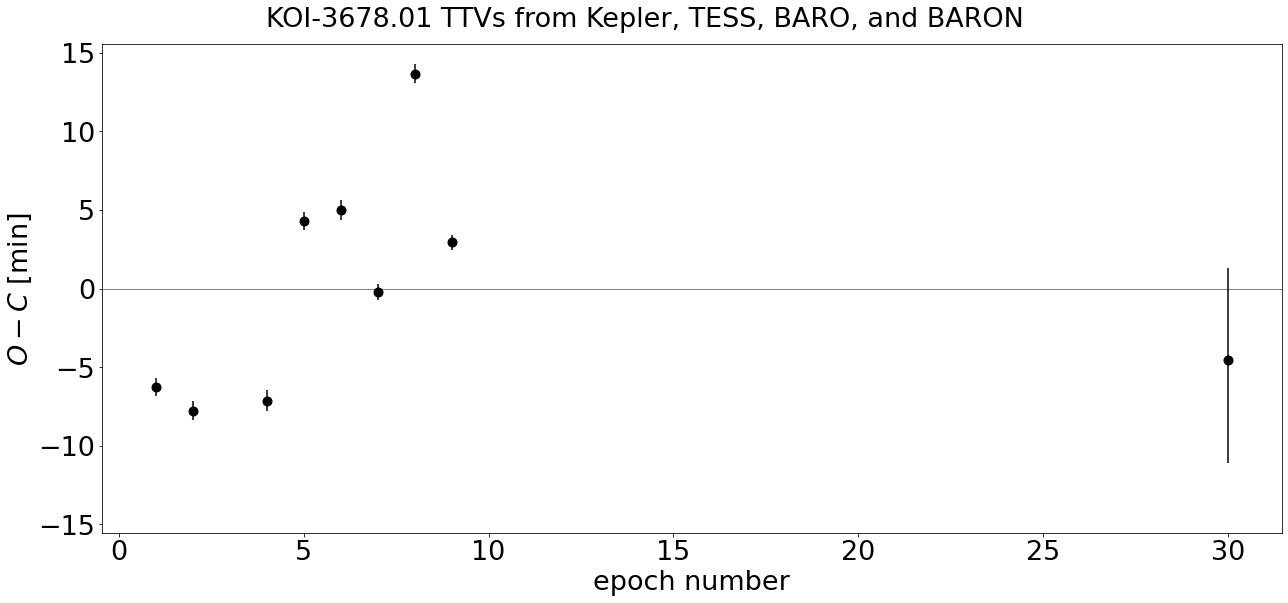

In [74]:
import pandas as pd

#kepler_ttvs = pd.read_csv('./koi-3678_TTVs_all_TESS.csv')

#flat_samps = trace.posterior.stack(sample=("chain", "draw"))

fig, ax1 = plt.subplots(1, 1, figsize=(18, 8.5), sharex=True)

ax1.errorbar(epochs+1, ttvs_median, yerr = tts_err, 
             ls = '', marker = 'o', color = 'k', markersize=9)
ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))

ax1.set_ylabel("$O-C$ [min]", fontsize=27)
ax1.set_xlabel("epoch number", fontsize=27)

fig.suptitle("KOI-3678.01 TTVs from Kepler, TESS, BARO, and BARON", fontsize=27)

fig.tight_layout()
fig.savefig('./koi-3678_TTVs.pdf')



In [82]:
import pandas as pd

detrend_dict = {}

detrend_dict["epochs"] = trans_inds
detrend_dict["times"] = tts_median
detrend_dict["ttvs"] = ttvs_median
detrend_dict["times_low_err"] = tts_err[0]
detrend_dict["times_high_err"] = tts_err[1]
    
detrend_df = pd.DataFrame(detrend_dict)

detrend_df.to_csv('./koi-3678_times_ttvs.csv', index=False)

In [185]:
import pandas as pd

detrend_dict = {}

detrend_dict["epochs"] = trans_inds
detrend_dict["transit_time_median"] = tts_median
detrend_dict["transit_time_1sigma_low"] = tts_err[0]
detrend_dict["transit_time_1sigma_high"] = tts_err[1]
    
detrend_df = pd.DataFrame(detrend_dict)

detrend_df.to_csv('./koi-3678_transit_times_all_TESS.csv', index=False)